Please install the necessary libraries using your terminal/shell in your env before running the code. You can check all the libraries mentioned in the next code block. To install any library you can use either one of the code mentioned below

pip install library_name

pip3 install library_name

In [2]:
import os
import glob
import yaml
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import json
from matplotlib.backends.backend_pdf import PdfPages
import warnings

warnings.filterwarnings('ignore')

class_name = { 0: 'Mass',
1: 'Spiculation',
2: 'Suspicious Calcification',
3: 'Architectural Distortion',
4: 'Asymmetry',
5: 'Focal Asymmetry',
6: 'Skin Thickening',
7: 'Global Asymmetry',
8: 'Suspicious Lymph Node',
9: 'Skin Retraction',
10: 'Nipple Retraction'
}

color_dict = {
    0: (255, 0, 0),      # Red
    1: (0, 255, 0),      # Green
    2: (0, 0, 255),      # Blue
    3: (255, 255, 0),    # Yellow
    4: (255, 165, 0),    # Orange
    5: (128, 0, 128),    # Purple
    6: (0, 255, 255),    # Cyan
    7: (255, 192, 203),  # Pink
    8: (128, 128, 0),    # Olive
    9: (0, 0, 0),        # Black
    10: (169, 169, 169)  # Dark Grey
}

Mention dataset.yaml file path and run

In [3]:
path = "dataset.yaml"

def remove_cache_files(directory):
    cache_files = glob.glob(os.path.join(directory, "*.cache"))
    for cache_file in cache_files:
        os.remove(cache_file)
        print(f"Removed: {cache_file}")
        
with open(path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)

remove_cache_files(os.path.dirname(data_loaded['train']))
remove_cache_files(os.path.dirname(data_loaded['val']))

Removed: /home/rshah133/bcd/dataset/split_1/train/labels.cache
Removed: /home/rshah133/bcd/dataset/split_1/val/labels.cache


Change the model and hyperparameters.

* Epochs = keep minimum 200
* imgsz = change acc to your model assigned
* patience = number of epochs model will check for accuracy improvement and then stop if accuracy is not improving
* set device = [0,1] if you have 2 GPUs requested and device = 0 if only 1 GPU/CPU
* save = True, this will help you save the model checkpoints on its own 
* save_period = 10, this is the number of epochs after which model will save the checkpoints
* resume = True, if kernel crashes, model will continue training from the previous checkpoint
* iou = keep iou between 0.5-0.7 and check for best metrics (hyperparameter to play with)
* optimzer  = AdamW is the best for our model from what I have noticed. you can experiment if you want
* learning rate, momentum, and weight decay are few more hyperparamerts you can play with

In [4]:
model = YOLO('yolov8s.yaml')
results = model.train(data = path, epochs = 200, imgsz = 1024, batch = 10, name = 'checkpoint', device = [0,1], patience = 25, save = True, save_period = 10, exist_ok = True, resume = True, iou = 0.5, optimizer = 'AdamW')

New https://pypi.org/project/ultralytics/8.3.69 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.68 🚀 Python-3.11.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
                                                      CUDA:1 (NVIDIA A100-SXM4-80GB, 81156MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=dataset.yaml, epochs=200, time=None, patience=25, batch=10, imgsz=1024, save=True, save_period=10, cache=False, device=[0, 1], workers=8, project=None, name=checkpoint, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, aug

E0000 00:00:1738121681.150214  923098 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738121681.153136  923098 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

E0000 00:00:1738121772.290063  923677 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738121772.294071  923677 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/checkpoint', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=11
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /home/rshah133/bcd/dataset/split_1/train/labels... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 788.11it/s]


train: New cache created: /home/rshah133/bcd/dataset/split_1/train/labels.cache


/home/rshah133/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/rshah133/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val: Scanning /home/rshah133/bcd/dataset/split_1/val/labels... 25 im

val: New cache created: /home/rshah133/bcd/dataset/split_1/val/labels.cache
Plotting labels to runs/detect/checkpoint/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 16 dataloader workers
Logging results to runs/detect/checkpoint
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.59G      3.843      5.381      3.806         39       1024: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.76it/s]


                   all         25        125          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.44G      3.717      4.346      3.215         45       1024: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


                   all         25        125   0.000427     0.0258   0.000251    5.1e-05


      3/200      3.41G      3.533      4.026      2.987         58       1024:   5%|▌         | 1/20 [00:00<00:03,  5.51it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.42G      3.653      4.207      3.073         40       1024: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 18.38it/s]


                   all         25        125       0.25    0.00309   0.000152   4.74e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.33G      3.607      4.061      2.968         50       1024: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


                   all         25        125    0.00012    0.00893   6.71e-05   6.71e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       3.3G      3.559      4.138      2.966         47       1024: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


                   all         25        125     0.0013     0.0529   0.000868   0.000176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.39G      3.607      4.092      2.998         45       1024: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


                   all         25        125    0.00025     0.0185   0.000137   4.25e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.36G       3.61      4.149      2.991         43       1024: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


                   all         25        125      0.125     0.0216    0.00028   5.42e-05


      8/200      3.32G       3.58      3.893      3.118         18       1024:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.32G      3.685      4.055      3.005         57       1024: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


                   all         25        125   0.000223    0.00309   7.69e-05   2.25e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.43G      3.545      3.954      2.947         28       1024: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


                   all         25        125    0.00214    0.00154   0.000172   3.35e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.33G       3.59      3.921      2.933         31       1024: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


                   all         25        125    0.00073     0.0558   0.000454   0.000132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.36G      3.615      4.102      2.931         28       1024: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


                   all         25        125      0.128      0.012    0.00189   0.000557


     12/200      3.38G      3.615      3.536       2.96         42       1024:   5%|▌         | 1/20 [00:00<00:02,  6.49it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       3.4G      3.599      3.971      2.923         42       1024: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


                   all         25        125    0.00182     0.0321    0.00107     0.0003

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.43G      3.563      4.001      2.925         58       1024: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]


                   all         25        125      0.258     0.0239    0.00145   0.000344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.29G      3.523      3.932      3.002         30       1024: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


                   all         25        125      0.127     0.0321    0.00118   0.000255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.43G      3.658      3.863      2.918         56       1024: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  3.89it/s]

                   all         25        125    0.00154     0.0524    0.00104    0.00044


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.42G      3.598      3.791      2.881         27       1024: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


                   all         25        125      0.127    0.00723     0.0011   0.000376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.36G      3.549      3.782      2.896         51       1024: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  2.43it/s]

                   all         25        125    0.00155     0.0347   0.000939   0.000323


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.59G      3.634      3.961      2.924         82       1024: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


                   all         25        125    0.00138     0.0529    0.00098   0.000242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.33G       3.51      3.756      2.872         50       1024: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


                   all         25        125    0.00132     0.0761   0.000964   0.000252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.31G      3.545      3.817      2.836         23       1024: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


                   all         25        125      0.256     0.0108    0.00454   0.000743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.44G      3.576      3.869      2.884         38       1024: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


                   all         25        125    0.00223     0.0743    0.00229   0.000451


     22/200       3.3G      3.491      4.075      2.944         32       1024:   5%|▌         | 1/20 [00:00<00:02,  8.44it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       3.3G      3.566      4.097      2.885         22       1024: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.07it/s]


                   all         25        125    0.00155      0.111    0.00223   0.000507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200       3.3G      3.533      3.804      2.861         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


                   all         25        125   0.000965     0.0844    0.00129    0.00025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.41G      3.524      3.738      2.934         32       1024: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  6.38it/s]

                   all         25        125     0.0011     0.0881    0.00203   0.000416


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.42G      3.552      3.605      2.954         41       1024: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


                   all         25        125    0.00155      0.118    0.00214   0.000406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.31G       3.54      3.636      2.929         35       1024: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


                   all         25        125      0.001      0.053   0.000641   9.28e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       3.4G      3.587      3.745      2.883         45       1024: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


                   all         25        125      0.127      0.036    0.00112   0.000181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       3.3G       3.54      3.804      2.889         22       1024: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


                   all         25        125      0.128     0.0299    0.00151   0.000476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.37G      3.533      3.765      2.875         47       1024: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  7.17it/s]

                   all         25        125      0.128     0.0357    0.00134   0.000259


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       3.4G      3.551          4      2.875         51       1024: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


                   all         25        125    0.00225     0.0388    0.00138   0.000343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200       3.3G       3.52       3.66      2.828         56       1024: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.94it/s]


                   all         25        125    0.00304      0.161     0.0038   0.000862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200       3.3G       3.52      3.725      2.842         28       1024: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 18.67it/s]


                   all         25        125    0.00244      0.155     0.0085    0.00218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.39G      3.516      3.768      2.861         32       1024: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


                   all         25        125    0.00155      0.125    0.00215   0.000555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.29G      3.538      3.843      2.855         63       1024: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00, 12.16it/s]

                   all         25        125    0.00308       0.13    0.00537    0.00152


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.06it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       3.3G      3.456      3.605      2.852         33       1024: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


                   all         25        125    0.00208     0.0898    0.00299   0.000647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.44G      3.442      3.796      2.887         39       1024: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.61it/s]


                   all         25        125      0.194    0.00723    0.00846    0.00262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.42G        3.5      3.626      2.924         56       1024: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


                   all         25        125    0.00181      0.129    0.00148   0.000409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.31G      3.453      3.568      2.859         37       1024: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


                   all         25        125    0.00303       0.17     0.0104    0.00284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.42G       3.43      3.574      2.866         66       1024: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.94it/s]


                   all         25        125    0.00265      0.178    0.00969    0.00227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.33G      3.442      3.654       2.88         32       1024: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

                   all         25        125     0.0022     0.0304    0.00565    0.00204


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 18.52it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.32G      3.431      3.696      2.904         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00, 11.78it/s]

                   all         25        125      0.172     0.0103     0.0136    0.00368


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.42G      3.424      3.648      2.873         17       1024: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


                   all         25        125      0.289    0.00568    0.00739    0.00209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.34G      3.385      3.699      2.831         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.34it/s]


                   all         25        125      0.463    0.00723    0.00997    0.00325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.33G      3.438      3.557      2.856         44       1024: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


                   all         25        125    0.00295      0.099     0.0067    0.00262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.45G      3.341       3.57      2.827         36       1024: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 19.45it/s]


                   all         25        125    0.00299     0.0974    0.00597    0.00185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.46G      3.429      3.689      2.868         42       1024: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.90it/s]


                   all         25        125    0.00358     0.0922    0.00956    0.00355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.42G      3.393      3.621      2.837         36       1024: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.17it/s]


                   all         25        125    0.00473     0.0275     0.0027   0.000914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.39G      3.333      3.559      2.882         41       1024: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


                   all         25        125     0.0243      0.026    0.00762    0.00384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.31G      3.332      3.554      2.841         43       1024: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.68it/s]


                   all         25        125       0.19    0.00568     0.0114     0.0041

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.45G       3.26      3.563      2.784         54       1024: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


                   all         25        125    0.00168      0.125    0.00264   0.000497


     51/200      3.52G       3.29      3.736       2.77         63       1024:   5%|▌         | 1/20 [00:00<00:02,  8.37it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.53G      3.157      3.531      2.764         49       1024: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


                   all         25        125      0.273    0.00568    0.00569    0.00127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.31G      3.259      3.758      2.747         63       1024: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.95it/s]


                   all         25        125    0.00195     0.0882    0.00229   0.000841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.42G      3.221      3.584      2.769         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00, 13.12it/s]

                   all         25        125    0.00234      0.073    0.00488    0.00201


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.71it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.56G      3.248      3.534      2.794         45       1024: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.46it/s]


                   all         25        125    0.00226      0.079     0.0051    0.00178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.46G      3.181      3.556      2.769          9       1024: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.37it/s]


                   all         25        125    0.00235      0.124    0.00499    0.00116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       3.3G      3.234      3.625      2.758         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.68it/s]


                   all         25        125      0.172    0.00723     0.0156    0.00473


     57/200      3.39G      3.257      3.568      2.789         37       1024:   5%|▌         | 1/20 [00:00<00:03,  6.14it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.41G      3.236      3.603      2.738         24       1024: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.43it/s]


                   all         25        125    0.00239      0.101    0.00381   0.000926


KeyboardInterrupt: 


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.37G      3.212      3.464      2.825         25       1024: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.94it/s]


                   all         25        125      0.402    0.00877     0.0118    0.00445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.34G        3.2      3.521      2.762         40       1024: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


                   all         25        125     0.0212      0.016     0.0128    0.00384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200       3.4G      3.168      3.505      2.766         47       1024: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


                   all         25        125    0.00111     0.0765     0.0012   0.000343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200       3.3G      3.103      3.505      2.709         58       1024: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


                   all         25        125      0.348    0.00568    0.00914    0.00383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.31G      3.066      3.346      2.703         22       1024: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.14it/s]


                   all         25        125       0.15    0.00723    0.00977    0.00411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200       3.4G      3.129      3.527      2.673         36       1024: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.78it/s]


                   all         25        125      0.281     0.0145     0.0135    0.00406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.45G      3.056      3.465      2.731         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]


                   all         25        125      0.308    0.00568    0.00564    0.00169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.46G      3.086      3.475      2.629         54       1024: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.51it/s]


                   all         25        125    0.00164      0.106    0.00699    0.00369


     66/200      3.38G       3.03      3.879      2.644         22       1024:   5%|▌         | 1/20 [00:00<00:03,  6.26it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       3.4G      3.082      3.508      2.582         44       1024: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


                   all         25        125    0.00189      0.129    0.00183   0.000394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.34G      3.022      3.459      2.622         39       1024: 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


                   all         25        125    0.00205     0.0711    0.00174   0.000505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200       3.3G      3.161        3.5      2.678         57       1024: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


                   all         25        125     0.0419     0.0274    0.00871    0.00249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200       3.4G        3.1      3.674      2.677         38       1024: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00, 12.49it/s]

                   all         25        125     0.0142      0.017     0.0107    0.00356


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.66it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.42G      3.013      3.534      2.591         51       1024: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.56it/s]


                   all         25        125      0.346    0.00568    0.00918    0.00268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.44G      3.017      3.562      2.587         59       1024: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.85it/s]


                   all         25        125      0.328    0.00568    0.00835    0.00303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.44G      3.029      3.386      2.594         39       1024: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.25it/s]


                   all         25        125      0.268     0.0723     0.0163    0.00436


     73/200      3.29G      3.039       3.31      2.653         30       1024:   5%|▌         | 1/20 [00:00<00:02,  6.67it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.29G      2.958        3.5      2.539         54       1024: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.99it/s]


                   all         25        125     0.0647    0.00723    0.00928     0.0026

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.29G      2.972      3.393      2.563         24       1024: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


                   all         25        125      0.154    0.00568    0.00765    0.00391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.39G      2.935      3.276       2.53         46       1024: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 24.04it/s]


                   all         25        125     0.0133      0.178     0.0209    0.00855


  0%|          | 0/20 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.45G      2.968      3.379      2.584         48       1024: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.49it/s]


                   all         25        125    0.00963      0.243      0.035     0.0124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.34G      2.901      3.406      2.521         50       1024: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.06it/s]


                   all         25        125    0.00289      0.141    0.00872    0.00248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.46G      2.962      3.487       2.55         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 18.77it/s]


                   all         25        125     0.0041      0.123    0.00683    0.00211


     79/200      3.29G      2.771      2.886      2.378         69       1024:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.29G      2.925       3.22      2.531         52       1024: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.28it/s]


                   all         25        125    0.00349     0.0687    0.00921    0.00245


     80/200      3.33G      2.927       3.37      2.611         47       1024:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.33G      2.905      3.275      2.535         33       1024: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


                   all         25        125    0.00194     0.0833    0.00133   0.000378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       3.4G      3.052      3.334      2.588         42       1024: 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.80it/s]


                   all         25        125    0.00535     0.0428    0.00483    0.00173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       3.3G      2.873      3.361      2.515         61       1024: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.93it/s]


                   all         25        125    0.00497     0.0931      0.008    0.00198


     83/200      3.46G       3.02      3.364      2.704         29       1024:   5%|▌         | 1/20 [00:00<00:03,  6.17it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.46G       2.92      3.283      2.628         26       1024: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


                   all         25        125      0.395     0.0423     0.0175    0.00547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.44G       2.96      3.314      2.559         45       1024: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.82it/s]


                   all         25        125    0.00373      0.153      0.016    0.00488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200       3.3G      2.881      3.194      2.547         64       1024: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.53it/s]


                   all         25        125      0.424     0.0409     0.0246    0.00761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.45G      2.834      3.211      2.508         40       1024: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00, 12.23it/s]

                   all         25        125      0.475      0.016     0.0235    0.00558


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.39it/s]
     87/200       3.4G      2.722       2.95      2.375         34       1024:   5%|▌         | 1/20 [00:00<00:02,  6.64it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.41G        2.9      3.217      2.504         30       1024: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.71it/s]


                   all         25        125      0.398     0.0145     0.0144    0.00434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.36G      2.866      3.316      2.455         64       1024: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.09it/s]


                   all         25        125      0.458     0.0217     0.0309    0.00952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.32G      2.836      3.125      2.471         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


                   all         25        125      0.254     0.0275    0.00175   0.000382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.44G      2.851      3.301      2.517         38       1024: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


                   all         25        125      0.251     0.0275   0.000624   0.000147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.42G      2.871      3.447      2.519         41       1024: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


                   all         25        125      0.254     0.0175    0.00306   0.000598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       3.3G      2.824      3.268      2.446         74       1024: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00, 16.53it/s]

                   all         25        125      0.401     0.0145     0.0218      0.006


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.64it/s]
     93/200      3.42G      2.773      3.251      2.512         32       1024:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.44G      2.833      3.325      2.491         36       1024: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


                   all         25        125      0.579     0.0232     0.0317     0.0069

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       3.3G      2.825      3.202      2.502         25       1024: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.74it/s]


                   all         25        125       0.45     0.0247     0.0224    0.00504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.31G      2.837      3.147      2.481         26       1024: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.83it/s]


                   all         25        125      0.439     0.0186     0.0149    0.00456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.44G      2.772      3.185      2.462         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


                   all         25        125      0.414    0.00877     0.0166    0.00486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200       3.3G      2.721      3.154      2.468         24       1024: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.94it/s]


                   all         25        125      0.443     0.0274     0.0304    0.00691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.36G       2.86      3.259      2.472         25       1024: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.90it/s]


                   all         25        125      0.507    0.00723    0.00175   0.000333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.39G       2.73       3.09      2.383         46       1024: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 24.73it/s]


                   all         25        125       0.61     0.0278     0.0358     0.0102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.43G      2.744      3.104      2.413         25       1024: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

                   all         25        125       0.72     0.0148     0.0316    0.00903


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 24.03it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200       3.3G      2.748      3.185      2.455         46       1024: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.84it/s]


                   all         25        125      0.546      0.033     0.0365     0.0124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.42G      2.726      2.998      2.425         48       1024: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


                   all         25        125      0.599     0.0451     0.0452     0.0142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.36G      2.743      3.193      2.468         38       1024: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.22it/s]


                   all         25        125      0.606     0.0304     0.0349     0.0122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.33G      2.755      3.178      2.429         31       1024: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.41it/s]


                   all         25        125      0.456      0.035     0.0282    0.00758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.59G      2.732      3.002      2.391         43       1024: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.80it/s]


                   all         25        125      0.418      0.016     0.0156    0.00339


    106/200      3.34G      2.794      2.859      2.446         48       1024:   5%|▌         | 1/20 [00:00<00:02,  6.50it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.34G      2.671      2.979       2.36         37       1024: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.95it/s]


                   all         25        125      0.429     0.0232     0.0207     0.0057

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.33G      2.706      3.101      2.383         35       1024: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.68it/s]


                   all         25        125      0.445    0.00723    0.00993    0.00319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.52G       2.81      3.065      2.403         31       1024: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


                   all         25        125    0.00235     0.0991    0.00426   0.000972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.29G      2.771      3.151      2.462         28       1024: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.84it/s]


                   all         25        125      0.392     0.0145    0.00546    0.00145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.42G      2.824      3.067      2.497         33       1024: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

                   all         25        125    0.00276      0.102     0.0124    0.00524


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.79it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200       3.4G      2.726      3.109      2.477         37       1024: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.30it/s]


                   all         25        125      0.401    0.00723    0.00697    0.00309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.29G       2.72       3.09      2.423         22       1024: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.52it/s]


                   all         25        125       0.45     0.0248     0.0338      0.011

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.42G      2.721      2.982      2.404         16       1024: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.61it/s]


                   all         25        125      0.455      0.023     0.0239    0.00499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.42G      2.711      3.043        2.4         28       1024: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.56it/s]


                   all         25        125      0.453     0.0622     0.0506     0.0157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.32G      2.679      2.993      2.409         41       1024: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.19it/s]


                   all         25        125      0.803    0.00568    0.00544    0.00209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.29G      2.597      3.001      2.332         45       1024: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.79it/s]


                   all         25        125      0.638    0.00568    0.00256   0.000859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.39G      2.596       2.99      2.337         29       1024: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


                   all         25        125      0.595     0.0657     0.0576      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200       3.3G      2.632      2.806      2.398         40       1024: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 24.57it/s]


                   all         25        125      0.698     0.0349      0.019     0.0051

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.36G      2.726      2.941      2.433         44       1024: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


                   all         25        125      0.559     0.0221     0.0309     0.0112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.59G      2.623      2.983      2.393         25       1024: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.01it/s]


                   all         25        125      0.509     0.0523      0.121     0.0269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.33G      2.677      2.923      2.452         50       1024: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.40it/s]


                   all         25        125      0.478     0.0294     0.0426     0.0145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.35G      2.659      2.862      2.395         59       1024: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


                   all         25        125      0.431     0.0438     0.0396     0.0148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       3.4G      2.682      3.153      2.402         26       1024: 100%|██████████| 20/20 [00:02<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.52it/s]


                   all         25        125      0.465     0.0702      0.181     0.0318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.32G      2.606      2.814       2.36         45       1024: 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.26it/s]


                   all         25        125      0.394     0.0403     0.0135    0.00729


    125/200      3.48G      2.603      3.125      2.268         45       1024:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.48G      2.605      2.931      2.357         55       1024: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.66it/s]


                   all         25        125      0.583     0.0495        0.1     0.0352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.52G      2.541      2.799      2.292         25       1024: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.99it/s]


                   all         25        125      0.569     0.0511     0.0632     0.0222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.45G      2.651      2.903      2.359         46       1024: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.92it/s]


                   all         25        125       0.46      0.027     0.0323     0.0138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.29G      2.664      3.048      2.435         76       1024: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.61it/s]


                   all         25        125      0.578      0.032     0.0558     0.0222


    129/200      3.55G       2.55      2.805      2.315         47       1024:   5%|▌         | 1/20 [00:00<00:02,  6.48it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.56G      2.674      3.013      2.369         60       1024: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.86it/s]


                   all         25        125      0.548     0.0313     0.0199    0.00797


    130/200      3.29G      3.102      3.306      2.379         21       1024:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.29G      2.621      2.945      2.354         32       1024: 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.91it/s]


                   all         25        125      0.561     0.0537     0.0519     0.0213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200       3.3G      2.498      2.845      2.311         67       1024: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.24it/s]


                   all         25        125      0.697     0.0263     0.0343     0.0144


    132/200      3.53G        2.8      3.157       2.58         50       1024:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.55G      2.553      2.896      2.379         38       1024:  85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

In [5]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

    133/200      3.36G      2.374      2.642      2.215         37       1024:  65%|██████▌   | 13/20 [00:01<00:00,  8.40it/s]

    133/200      3.36G      2.427      2.723      2.272         42       1024: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


                   all         25        125      0.592     0.0385     0.0487     0.0202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.29G      2.555      2.746      2.264         44       1024: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 24.41it/s]


                   all         25        125      0.401     0.0428     0.0233    0.00828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.52G      2.529      2.821      2.309         44       1024: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 18.74it/s]


                   all         25        125      0.496     0.0438      0.063     0.0242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200       3.3G        2.5      2.832      2.304         33       1024: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.57it/s]


                   all         25        125      0.418     0.0201     0.0229    0.00733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.41G      2.506      2.705      2.275         64       1024: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


                   all         25        125      0.395     0.0248     0.0129    0.00531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200       3.4G      2.593       2.96      2.331         64       1024: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.52it/s]


                   all         25        125      0.562     0.0697      0.073     0.0234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.31G      2.593       2.97      2.281         36       1024: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.95it/s]


                   all         25        125      0.414     0.0248     0.0164    0.00776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.42G      2.519      2.789      2.275         29       1024: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.18it/s]


                   all         25        125      0.475     0.0688      0.082     0.0331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.53G      2.463      2.651      2.256         35       1024: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.57it/s]


                   all         25        125      0.413     0.0294     0.0173    0.00626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.29G      2.569      2.758      2.268         52       1024: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


                   all         25        125      0.587     0.0743     0.0991     0.0367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.36G      2.553      2.763      2.302         59       1024: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


                   all         25        125      0.404      0.016     0.0112     0.0044

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.46G       2.51      2.832      2.297         46       1024: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.82it/s]


                   all         25        125      0.562     0.0263     0.0285     0.0132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.46G      2.483      2.801      2.278         40       1024: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 24.56it/s]


                   all         25        125      0.561     0.0278     0.0307     0.0146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.44G      2.588      2.857      2.314         59       1024: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.91it/s]


                   all         25        125      0.538     0.0377     0.0195    0.00846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.44G       2.53      2.736      2.233         62       1024: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.32it/s]


                   all         25        125       0.55      0.103      0.106     0.0378


    148/200      3.33G      2.483      2.727      2.211         59       1024:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.33G      2.455      2.701      2.209         61       1024: 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.91it/s]


                   all         25        125      0.577     0.0335     0.0332     0.0139
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 123, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

148 epochs completed in 0.156 hours.
Optimizer stripped from runs/detect/checkpoint/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/checkpoint/weights/best.pt, 22.6MB

Validating runs/detect/checkpoint/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
                                                      CUDA:1 (NVIDIA A100-SXM4-80GB, 81156MiB)
YOLOv8s summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


                   all         25        125      0.465     0.0701       0.18     0.0317
                  Mass         15         22      0.245      0.364      0.241      0.093
           Spiculation         25         81      0.338      0.126      0.136      0.044
Suspicious Calcification         10         14      0.135     0.0714     0.0437    0.00894
Architectural Distortion          3          3          1          0     0.0257    0.00833
             Asymmetry          1          1          1          0          0          0
       Skin Thickening          2          2          0          0          0          0
 Suspicious Lymph Node          1          1          1          0      0.995     0.0995
     Nipple Retraction          1          1          0          0          0          0
Speed: 0.8ms preprocess, 1.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/checkpoint


/home/rshah133/bcd/dataset/split_1/val/images/66d5d94402456f664753ec443d077bf9.jpg

0: 1024x1024 3 Masss, 5.2ms
Speed: 3.6ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)
[[     452.69      249.78      531.27      346.69]
 [     446.32       253.2      548.27      356.14]
 [     461.63      251.18      561.18      344.57]]
[          0           0           0]
[(452.6928, 249.78088, 531.26776, 346.69135), (446.31647, 253.19763, 548.265, 356.13678), (461.63477, 251.1782, 561.1776, 344.56558)] [(255, 0, 0), (255, 0, 0), (255, 0, 0)] [0, 0, 0]
(452.6928, 249.78088, 531.26776, 346.69135) (255, 0, 0) 0
(446.31647, 253.19763, 548.265, 356.13678) (255, 0, 0) 0
(461.63477, 251.1782, 561.1776, 344.56558) (255, 0, 0) 0


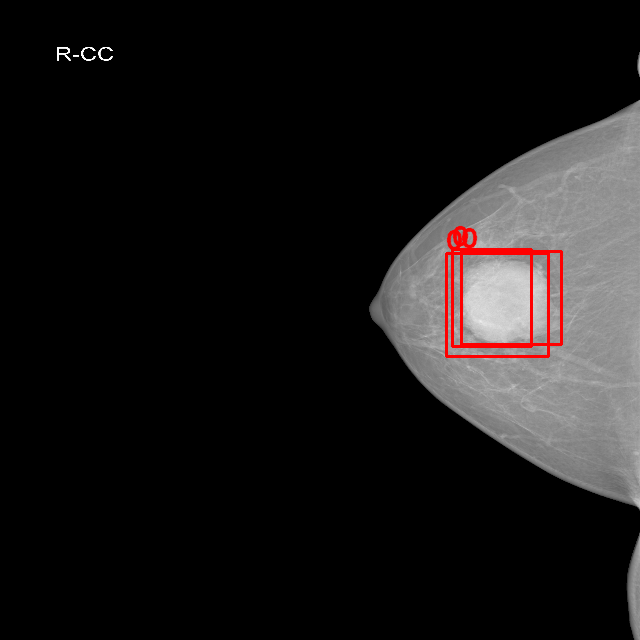

In [140]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    boxes, colors, names = [], [], []

    for result in results:
        
        confidence = result.boxes.conf.cpu().numpy()
        # if confidence[0] < 0.2:
        #     continue
        
        box = result.boxes.xyxy.cpu().numpy()
        print(box)
        # xmin, ymin, xmax, ymax = box[0]
        
        category = result.boxes.cls.cpu().numpy()
        print(category)
        
        for b, c, co in zip(box, category, confidence):
            xmin, ymin, xmax, ymax = b
            category = int(c)
            # color = COLORS[int(category)]
        
            boxes.append((xmin, ymin, xmax, ymax))
            colors.append((255, 0, 0))
            names.append(category)
        
        
    return boxes, colors, names

    # detections = results.xyxy[0]
    # print(results)
    # detections = detections.to_dict()

    # for i in range(len(detections["xmin"])):
        # confidence = detections["confidence"][i]
        # if confidence < 0.2:
        #     continue
        # xmin = int(detections["xmin"][i])
        # ymin = int(detections["ymin"][i])
        # xmax = int(detections["xmax"][i])
        # ymax = int(detections["ymax"][i])
        # name = detections["name"][i]
        # category = int(detections["class"][i])
        # color = COLORS[category]

        # boxes.append((xmin, ymin, xmax, ymax))
        # colors.append(color)
        # names.append(name)
    # return boxes, colors, names

def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        print(box, color, name)
        xmin, ymin, xmax, ymax = map(int,box)
        cv2.rectangle(img,(xmin, ymin),(xmax, ymax),color, 2)

        cv2.putText(img, str(name), (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, lineType=cv2.LINE_AA)
    return img


img_path = os.path.join(data_loaded['val'], os.listdir(data_loaded['val'])[2])
img = cv2.imread(img_path)
print(img_path)
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# axs[0].imshow(cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB))


img = np.float32(rgb_img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = YOLO('runs/detect/checkpoint/weights/best.pt')
model.eval()
# model.cpu()
target_layers = [model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)

print(boxes, colors, names)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

In [142]:
type(tensor)

torch.Tensor

In [153]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import numpy as np
from PIL import Image

# Ensure that the model is on the correct device (either 'cuda' or 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)  # Move the model to the correct device

# Ensure the input tensor is on the same device as the model
tensor = tensor.to(device)  # Move the tensor to the correct device

# Initialize EigenCAM with the model and target layers
cam = EigenCAM(model, target_layers)

# Get the CAM for the tensor input
# EigenCAM returns a list of results. We get the first one (as it's a batch of size 1)
grayscale_cam = cam(tensor)[0]  # No need to manually index for channels, as it handles it

# Convert the CAM to a numpy array for visualization
grayscale_cam = grayscale_cam.cpu().detach().numpy()

# Now visualize the CAM
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# Convert the resulting image to a PIL image
pil_cam_image = Image.fromarray(cam_image)

# Display the CAM image
pil_cam_image.show()



0: 640x640 4 Masss, 11 Spiculations, 6.3ms
Speed: 0.0ms preprocess, 6.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'list' object has no attribute 'cpu'

In [154]:
from YOLOv8_Explainer import yolov8_heatmap, display_images

model = yolov8_heatmap(
    weight="/home/rshah133/bcd/v8n_1024/runs/detect/checkpoint/weights/best.pt", 
        conf_threshold=0.4,  
        method = "GradCAM", 
        layer=[10, 12, 14, 16, 18, -3],
        ratio=0.02,
        show_box=True,
        renormalize=False,)

imagelist = model(
    img_path="/home/rshah133/bcd/dataset/split_1/val/images/94ded0fb1036a6f4f044beba047b8d3a.jpg", 
    )

display_images(imagelist)


YOLOv8s summary: 225 layers, 11,139,857 parameters, 0 gradients, 28.7 GFLOPs


Exception ignored in: <function BaseCAM.__del__ at 0x1553f2b96480>
Traceback (most recent call last):
  File "/home/rshah133/.local/lib/python3.11/site-packages/pytorch_grad_cam/base_cam.py", line 189, in __del__
    targets, eigen_smooth)
^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

Implemented Tensorboard. Code will redirect you to a link which should be opened in **Google Chrome** if nothing is getting displayed on safari.  You can choose not to run this code block if you want to not see the dashboard and save time.

In [4]:
#!kill 1869322
%load_ext tensorboard
%tensorboard --logdir runs/detect/checkpoint

Reusing TensorBoard on port 6008 (pid 1877066), started 0:29:56 ago. (Use '!kill 1877066' to kill it.)

Mention test_dataset.yaml file path and run

In [4]:
test_path = "test_dataset.yaml"

with open(test_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)

remove_cache_files(os.path.dirname(data_loaded['train']))
remove_cache_files(os.path.dirname(data_loaded['val']))

Removed: /home/rshah133/bcd/dataset/test/labels.cache


Predicting on test data. Please set the prediction_progress.json to 0 by opening everytime when you want to predict on the test data from the start or it will resume from where it stopped last

In [ ]:
progress_file = 'prediction_progress.json'

def save_progress(current_index):
    with open(progress_file, 'w') as f:
        json.dump({'last_processed': current_index}, f)

def load_progress():
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as f:
            return json.load(f)['last_processed']
    return 0

# Loading the best model
best_model = YOLO('runs/detect/checkpoint/weights/best.pt')

test_img_path = data_loaded['val']

start_index = load_progress()

chunk_size = 48  # Adjust based on your available memory
for i in range(start_index, len(test_img_path), chunk_size):
    chunk_end = min(i + chunk_size, len(test_img_path))
    current_chunk = test_img_path[i:chunk_end]
    
    try:
        results = best_model.predict(source = current_chunk, save = True, save_txt = True, conf = 0.10, batch = chunk_size//4, stream = True)
        
        # code for post - processing results for later
        for r in results:
            pass  
            
        save_progress(chunk_end)
        
    except Exception as e:
        save_progress(i)
        print(f"Prediction stopped at image {i}. Progress saved.")
        raise e


/home/rshah133/bcd/dataset/test/images

image 1/763 /home/rshah133/bcd/dataset/test/images/001ade2a3cb53fd808bd2856a0df5413.jpg: 1024x1024 (no detections), 2.8ms
image 2/763 /home/rshah133/bcd/dataset/test/images/002074412a8fc178c271fb93b55c3e29.jpg: 1024x1024 2 Masss, 5 Spiculations, 2.8ms
image 3/763 /home/rshah133/bcd/dataset/test/images/005918369ec07b1aed37d1dd78bc57fe.jpg: 1024x1024 1 Mass, 2 Spiculations, 2.8ms
image 4/763 /home/rshah133/bcd/dataset/test/images/00857417d07096982013956033da1f75.jpg: 1024x1024 (no detections), 2.8ms
image 5/763 /home/rshah133/bcd/dataset/test/images/008bc6050f6d31fc255e5d87bcc87ba2.jpg: 1024x1024 1 Mass, 2 Spiculations, 2.8ms
image 6/763 /home/rshah133/bcd/dataset/test/images/00be38a5c0566291168fe381ba0028e6.jpg: 1024x1024 1 Spiculation, 2.8ms
image 7/763 /home/rshah133/bcd/dataset/test/images/00ec2be128f964da6f0b0ba179c4d138.jpg: 1024x1024 1 Mass, 1 Spiculation, 2.8ms
image 8/763 /home/rshah133/bcd/dataset/test/images/01599597388f3185563decc34945f

In [6]:
# best_model = YOLO('runs/detect/checkpoint/weights/best.pt')
# test_img_path = data_loaded['val']
# results = best_model.predict(source = test_img_path, save = True,  save_txt = True,  conf = 0.10, batch = 16)

Run this cell as it is and take screenshot of the output. This code is for calculating the metrics for test data

u can play with conf keep between 0.05-0.2 (for our use case). lower value means it predicts more but with less accuracy. 

In [13]:
metrics = best_model.val(data = test_path, conf = 0.10)

Ultralytics 8.3.68 🚀 Python-3.11.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81158MiB)


val: Scanning /home/rshah133/bcd/dataset/test/labels.cache... 763 images, 34 backgrounds, 0 corrupt: 100%|██████████| 763/763 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.64it/s]


                   all        763       1860      0.124     0.0364     0.0252    0.00971
                  Mass        388        451      0.216      0.333      0.217     0.0831
           Spiculation        263        810     0.0923     0.0593     0.0406     0.0157
Suspicious Calcification        280        358     0.0516    0.00806     0.0201    0.00799
Architectural Distortion         59         59          0          0          0          0
             Asymmetry          8          8          0          0          0          0
       Focal Asymmetry         93         93          0          0          0          0
       Skin Thickening         31         33          0          0          0          0
      Global Asymmetry          2          2          0          0          0          0
 Suspicious Lymph Node         27         30          1          0          0          0
       Skin Retraction          3          4          0          0          0          0
     Nipple Retra

In [5]:
def get_prediction_dirs():
    base_dir = "runs/detect"
    
    predict_dirs = [d for d in os.listdir(base_dir) if d.startswith('predict')]
    predict_dirs.sort(key=lambda x: int(x.replace('predict', '')) if x != 'predict' else 0)
    
    return f"{base_dir}/{predict_dirs[-1]}/labels"

predictions_dir = get_prediction_dirs()
predictions_dir

'runs/detect/predict/labels'

In [6]:
test_images_dir = data_loaded['val']
test_labels_dir = os.path.join(os.path.dirname(data_loaded['val']), 'labels')

output_labels_dir = "results/labels"  # Directory to save ground truth images
output_pred_dir = "results/predictions"  # Directory to save predicted images

# Create output directory if it doesn't exist
os.makedirs(output_labels_dir, exist_ok=True)
os.makedirs(output_pred_dir, exist_ok=True)

# Function to read YOLO format labels
def read_yolo_labels(label_file):
    labels = []
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            class_id, x_center, y_center, width, height = map(float, parts[:5])
            confidence = float(parts[5]) if len(parts) > 5 else None
            labels.append((int(class_id), x_center, y_center, width, height, confidence))
    return labels

# Function to draw bounding boxes on images
def draw_boxes(image, boxes):
    h, w, _ = image.shape
    for box in boxes:
        class_id, x_center, y_center, width, height, confidence = box
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)
        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color_dict[class_id], 2)
    return image

# Loop through each image
for image_file in os.listdir(test_images_dir):
    if image_file.endswith((".jpg", ".png", ".jpeg")):
        base_name = os.path.splitext(image_file)[0]
        image_path = os.path.join(test_images_dir, image_file)

        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading {image_file}")
            continue

        # Read ground truth labels
        ground_truth_file = os.path.join(test_labels_dir, f"{base_name}.txt")
        ground_truth_boxes = read_yolo_labels(ground_truth_file) if os.path.exists(ground_truth_file) else []

        # Read prediction labels
        prediction_file = os.path.join(predictions_dir, f"{base_name}.txt")
        prediction_boxes = read_yolo_labels(prediction_file) if os.path.exists(prediction_file) else []

        # Draw ground truth (green) and predictions (blue)
        image_with_boxes_gt = draw_boxes(image.copy(), ground_truth_boxes)
        image_with_boxes_pt = draw_boxes(image.copy(), prediction_boxes)

        # Save annotated image
        gt_output_path = os.path.join(output_labels_dir, image_file)
        cv2.imwrite(gt_output_path, image_with_boxes_gt)

        pt_output_path = os.path.join(output_pred_dir, image_file)
        cv2.imwrite(pt_output_path, image_with_boxes_pt)

print("Done saving the predictions")

Done saving the predictions


Code to combine images in a single pdf. This code take upto 20mins to execute

In [7]:
c = 0

output_labels_file_names = sorted(os.listdir(output_labels_dir))
output_pred_file_names = sorted(os.listdir(output_pred_dir))

pdf_file_path = "combined_images.pdf"
with PdfPages(pdf_file_path) as pdf:
    for label_file, pred_file in zip(output_labels_file_names[:5], output_pred_file_names[:5]):
        label_img = cv2.imread(os.path.join(output_labels_dir, label_file))
        pred_img = cv2.imread(os.path.join(output_pred_dir, pred_file))

        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f"Image: {label_file}", fontsize=12)
        axs[0].imshow(cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Ground Truth')
        axs[0].axis('off')
        axs[1].imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Prediction')
        axs[1].axis('off')
        plt.tight_layout()
        c += 1
        
        pdf.savefig(fig)
        plt.close(fig)

print(f"{c} prediction images saved in {pdf_file_path}")

5 prediction images saved in combined_images.pdf


This code block will display ground truth and predictions one by one in the notebook itself. Not required if combining in the pdf

In [ ]:
# %matplotlib inline

# output_labels_file_names = sorted(os.listdir(output_labels_dir))
# output_pred_file_names = sorted(os.listdir(output_pred_dir))

# for label_file, pred_file in zip(output_labels_file_names, output_pred_file_names):
#     label_img = cv2.imread(os.path.join(output_labels_dir, label_file))
#     pred_img = cv2.imread(os.path.join(output_pred_dir, pred_file))
    
#     fig, axs = plt.subplots(1, 2, figsize=(16, 6))
#     axs[0].imshow(cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB))
#     axs[0].set_title('Ground Truth')
#     axs[0].axis('off')
#     axs[1].imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
#     axs[1].set_title('Prediction')
#     axs[1].axis('off')
#     plt.tight_layout()
#     plt.show()